## Computation and visualization of Pose Errors

In [1]:
import numpy as np
import sys
sys.path.append('..')
from utils.np_utils.pose_evaluation_utils import *
from utils.np_utils.pose_helper import *
from utils.np_utils.helper import *
import pandas as pd

from utils.np_utils.pose_helper import make_intrinsic, Traj_helper
from utils.np_utils.viz_helper import *


#updated version from pose_evaluation_utils
def find_ate(gts,preds):

    gt, pred = gts[:,:3,-1],preds[:,:3,-1]

    offset = gt[0] - pred[0]

    pred += offset[None,:]

    # Optimize the scaling factor
    scale = np.sum(gt * pred)/np.sum(pred ** 2)
    pred = pred*scale
    alignment_error = pred - gt

    #average translation error
    rmse = np.sqrt(np.sum(alignment_error ** 2))/len(gt)

    preds[:,:3,-1] = pred
    return preds,rmse

def compute_error(gt_path,pred_path):
    gts = txt_to_4x4(gt_path)
    gts = align_to_origin(gts)
    preds = txt_to_4x4(pred_path)
    preds = align_to_origin(preds,True)

    preds_scaled,ate = find_ate(gts,preds)
    rpe = find_all_rpe(gts,preds_scaled)

    print(ate,rpe)
    return preds, preds_scaled

def compute_error_TUM(gt_path,pred_path):
    gts = txt_to_4x4(gt_path)
    gts = align_to_origin(gts)
    preds = txt_to_4x4(pred_path)
    
    p, trans_err = align(np.matrix(preds[:,:3,3].T),np.matrix(gts[:,:3,3].T))
    pred_scaled = np.copy(preds)
    pred_scaled[:,:3,3] = p.T
    print("TransErr = ", np.sqrt(np.dot(trans_err,trans_err) / len(trans_err)))

    _,ate = find_ate(gts,pred_scaled)
    rpe = find_all_rpe(gts,pred_scaled)

    print(ate,rpe)
    return preds, pred_scaled

''' 
Display various stats using Translational and Rotational error

print "compared_pose_pairs %d pairs"%(len(trans_error))

print "translational_error.rmse %f m"%numpy.sqrt(numpy.dot(trans_error,trans_error) / len(trans_error))
print "translational_error.mean %f m"%numpy.mean(trans_error)
print "translational_error.median %f m"%numpy.median(trans_error)
print "translational_error.std %f m"%numpy.std(trans_error)
print "translational_error.min %f m"%numpy.min(trans_error)
print "translational_error.max %f m"%numpy.max(trans_error)

print "rotational_error.rmse %f deg"%(numpy.sqrt(numpy.dot(rot_error,rot_error) / len(rot_error)) * 180.0 / numpy.pi)
print "rotational_error.mean %f deg"%(numpy.mean(rot_error) * 180.0 / numpy.pi)
print "rotational_error.median %f deg"%(numpy.median(rot_error) * 180.0 / numpy.pi)
print "rotational_error.std %f deg"%(numpy.std(rot_error) * 180.0 / numpy.pi)
print "rotational_error.min %f deg"%(numpy.min(rot_error) * 180.0 / numpy.pi)
print "rotational_error.max %f deg"%(numpy.max(rot_error) * 180.0 / numpy.pi)
'''
1

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


1

In [2]:
gt_path = '../data/Trajs/abandonedfactory_night/P001.txt'
pred_path = '../data/traj_Factory_night_0001.txt'

bp, preds = compute_error_TUM(gt_path, pred_path)   # Less Loss, Less Sense
bp2,preds2= compute_error(gt_path, pred_path)       # More Loss, better sence   # Using this

TransErr =  39.20777658325479
0.3231317099357854 (0.3141236196159193, 0.03918972871547101)
0.5103990822988096 (0.3778498094956221, 0.03918972871547116)


In [4]:
helper = Traj_helper()
window = viewer()
window.init()
display_poses_dataset(window,f_name='../data/Trajs/abandonedfactory_night/P001.txt',color=[0,0.5,0],data_origin=True)
display_poses(window,preds,color=[1,0,0])
# display_poses(window,bp,color=[0.5,0,0])
display_poses(window,preds2,color=[0,0,1])
# display_poses(window,bp2,color=[0,0,0.5])

window.vis.run()

NameError: name 'preds' is not defined

: 

## Compiling trajectories 

In [2]:
import glob
from utils.np_utils.helper import txt_to_q

All_data = {}
for env in sorted(glob.glob('../data/Trajs/*')):
    temp = []
    for fnames in sorted(glob.glob(env+'/P*.txt')):
        if len(temp)==0:
            temp=txt_to_q(fnames)
        else:
            temp = np.concatenate((temp,txt_to_q(fnames)))
    All_data[env.split('/')[-1]] = np.array(temp)
    

In [3]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import networkx as nx


data = np.concatenate((All_data['abandonedfactory'],All_data['abandonedfactory_night']))
x,y,z,q1,q2,q3,q4 = data.T

idx = np.random.permutation(len(data))
xs,ys,zs,q1s,q2s,q3s,q4s = data[idx].T

points = np.c_[xs,ys,zs,q1s,q2s,q3s,q4s]

clf = NearestNeighbors(n_neighbors=2).fit(points)
G = clf.kneighbors_graph()
T = nx.from_scipy_sparse_array(G)

order = list(nx.dfs_preorder_nodes(T, 0))

# xx = x[order]
# yy = y[order]

xx,yy,zz,q1q,q2q,q3q,q4q = (data[idx])[order].T

paths = [list(nx.dfs_preorder_nodes(T, i)) for i in range(len(points))]


mindist = np.inf
minidx = 0

for i in range(len(points)):
    p = paths[i]           # order of nodes
    ordered = points[p]    # ordered nodes
    # find cost of that order by the sum of euclidean distances between points (i) and (i+1)
    cost = (((ordered[:-1] - ordered[1:])**2).sum(1)).sum()
    if cost < mindist:
        mindist = cost
        minidx = i

opt_order = paths[minidx]

xx,yy,zz,q1q,q2q,q3q,q4q = (data[idx])[opt_order].T

plt.plot(xx, yy)
plt.show()

KeyboardInterrupt: 

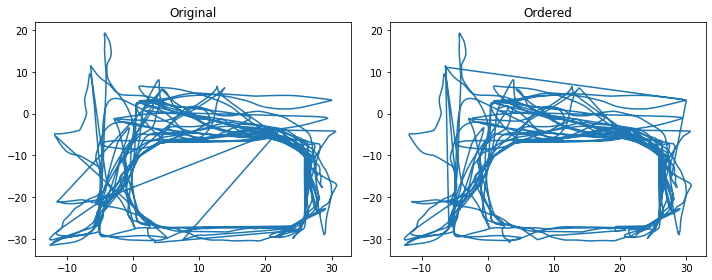

: 

In [8]:
# https://stackoverflow.com/questions/37742358/sorting-points-to-form-a-continuous-line
import matplotlib.pyplot as plt
def order_points(points, ind):
    points_new = [ points.pop(ind) ]  # initialize a new list of points with the known first point
    pcurr      = points_new[-1]       # initialize the current point (as the known point)
    while len(points)>0:
        d      = np.linalg.norm(np.array(points) - np.array(pcurr), axis=1)  # distances between pcurr and all other remaining points
        ind    = d.argmin()                   # index of the closest point
        points_new.append( points.pop(ind) )  # append the closest point to points_new
        pcurr  = points_new[-1]               # update the current point
    return points_new
# create sine curve:
# x      = np.linspace(0, 2 * np.pi, 100)
# y      = np.sin(x)
# xs = data[:,0]#np.linspace(0, 2 * np.pi, 1000)
# ys = data[:,1]#np.sin(x)
# zs = data[:,2]

data = All_data['abandonedfactory'][:10001]#np.concatenate((All_data['abandonedfactory'],All_data['abandonedfactory_night']))
# x,y,z,q1,q2,q3,q4 = data.T

# # shuffle the order of the x and y coordinates:
# idx    = np.random.permutation(x.size)
# xs,ys,zs  = x[idx], y[idx],   # shuffled points

d1 = np.copy(data)
idx = np.random.permutation(len(data))
data = [pose_vec_q_to_mat(i) for i in data[idx]]

# find the leftmost point:
ind    = 0#data.argmin()

# assemble the x and y coordinates into a list of (x,y) tuples:
points = list(data)#[(xx,yy,zz)  for xx,yy,zz in zip(x,y,z)]
points = list(np.array(points).reshape((len(points),16)))

# order the points based on the known first point:
points_new = order_points(points, ind)

# plot:
fig,ax = plt.subplots(1, 2, figsize=(10,4))
data  = np.array(points_new)
ax[0].plot(d1[:,0], d1[:,1])  # original (shuffled) points
ax[1].plot(data[:,3], data[:,7])  # new (ordered) points
ax[0].set_title('Original')
ax[1].set_title('Ordered')
plt.tight_layout()
plt.show()


In [6]:
data = data.reshape((len(data),4,4))
bdata = np.copy(data)
# data = np.copy(bdata)
data = [inv(data[0])@i for i in data]
udata = np.array([pose_mat_to_vec_q(i) for i in data]) #np.array([xn,yn,zn,q1n,q2n,q3n,q4n])

window = viewer()

window.init()

vis = window.vis
ctr = vis.get_view_control()
print("Field of view (before changing) %.2f" % ctr.get_field_of_view())
ctr.change_field_of_view(step=90)
print("Field of view (after changing) %.2f" % ctr.get_field_of_view())
vis.run()


window.vis.reset_view_point(True)
window.draw_dots_live(udata[:500])

window.run()

Field of view (before changing) 60.00
Field of view (after changing) 90.00


100%|██████████| 500/500 [00:08<00:00, 62.14it/s]


## Using Scipy

In [7]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# Define a function to read a trajectory from a file
def read_trajectory(file_path):
    trajectory = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            values = line.strip().split()
            pose = np.array([float(value) for value in values])
            trajectory.append(pose)
    return trajectory

# Load groundtruth and estimated trajectories
groundtruth_file = '/home/rp2/Projects/slambook2/ch4/example/groundtruth.txt'
estimated_file = '/home/rp2/Projects/slambook2/ch4/example/estimated.txt'

groundtruth = read_trajectory(groundtruth_file)
estimated = read_trajectory(estimated_file)

assert len(groundtruth) > 0 and len(estimated) > 0
assert len(groundtruth) == len(estimated)

# Compute RMSE
rmse = 0.0
for i in range(len(estimated)):
    p1 = R.from_matrix(estimated[i].reshape(3, 4)).as_matrix()
    p2 = R.from_matrix(groundtruth[i].reshape(3, 4)).as_matrix()
    error = np.linalg.norm(np.log(np.dot(np.linalg.inv(p2), p1)))
    rmse += error ** 2

rmse /= float(len(estimated))
rmse = np.sqrt(rmse)
print("RMSE =", rmse)


ValueError: cannot reshape array of size 8 into shape (3,4)

In [2]:
import numpy as np
import sys
sys.path.append('../')
from scipy.spatial.transform import Rotation as R
from scipy.linalg import logm, expm
from utils.np_utils.pose_helper import  pose_vec_q_to_mat, inv


# Define a function to read a trajectory from a file
def read_trajectory(file_path):
    trajectory = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        for line in lines:
            values = line.strip().split()
            pose = np.array([float(value) for value in values])
            trajectory.append(pose)
    return trajectory
# Load groundtruth and estimated trajectories
groundtruth_file = '/home/rp2/Projects/slambook2/ch4/example/groundtruth.txt'
estimated_file = '/home/rp2/Projects/slambook2/ch4/example/estimated.txt'

groundtruth = read_trajectory(groundtruth_file)
estimated = read_trajectory(estimated_file)


assert len(groundtruth) > 0 and len(estimated) > 0
assert len(groundtruth) == len(estimated)

# Compute RMSE
rmse = 0.0
for i in range(len(estimated)):
    
    T1 = pose_vec_q_to_mat(estimated[i][1:])
    T2 = pose_vec_q_to_mat(groundtruth[i][1:])
    # print(T1,'\n',T2)
    
    error = inv(T2)@T1
    # print(inv(T2))
    # print('error',error)
    rmse += np.linalg.norm(error[:3, 3])*np.linalg.norm(error[:3, 3]) 
    # rmse += error@error
# rmse = np.linalg.norm(rmse[:3,3])
rmse /= float(len(estimated))
rmse = np.sqrt(rmse)
print("RMSE =", rmse)


RMSE = 0.02310051498117494


In [5]:
import csv, binascii
import os
from evo.core.trajectory import PosePath3D, PoseTrajectory3D
from evo.core import lie_algebra, sync, metrics
from evo.core.metrics import PoseRelation, Unit
import typing
import scipy.spatial.transform as sst
from distutils.version import LooseVersion
from scipy import __version__ as scipy_version
from enum import Enum
import numpy as np
import math

_USE_DCM_NAME = LooseVersion(scipy_version) < LooseVersion("1.4")

def csv_read_matrix(file_path, delim=',', comment_str="#"):
    """
    directly parse a csv-like file into a matrix
    :param file_path: path of csv file (or file handle)
    :param delim: delimiter character
    :param comment_str: string indicating a comment line to ignore
    :return: 2D list with raw data (string)
    """
    if hasattr(file_path, 'read'):  # if file handle
        generator = (line for line in file_path
                     if not line.startswith(comment_str))
        reader = csv.reader(generator, delimiter=delim)
        mat = [row for row in reader]
    else:
        skip_3_bytes = has_utf8_bom(file_path)
        with open(file_path) as f:
            if skip_3_bytes:
                f.seek(3)
            generator = (line for line in f
                         if not line.startswith(comment_str))
            reader = csv.reader(generator, delimiter=delim)
            mat = [row for row in reader]
    return mat

def has_utf8_bom(file_path):
    """
    Checks if the given file starts with a UTF8 BOM
    wikipedia.org/wiki/Byte_order_mark
    """
    size_bytes = os.path.getsize(file_path)
    if size_bytes < 3:
        return False
    with open(file_path, 'rb') as f:
        return not int(binascii.hexlify(f.read(3)), 16) ^ 0xEFBBBF

def get_trajs(f_path):
    raw_mat = csv_read_matrix(f_path,delim=' ')
    error_msg = "TUM trajectory files must have 8 entries per row and no trailing delimiter at the end of the rows (space)"
    if not raw_mat or (len(raw_mat) > 0 and len(raw_mat[0]) != 8):
        raise error_msg
    try:
        mat = np.array(raw_mat).astype(float)
    except ValueError:
        raise error_msg
    stamps = mat[:, 0]  # n x 1
    xyz = mat[:, 1:4]  # n x 3
    quat = mat[:, 4:]  # n x 4
    quat = np.roll(quat, 1, axis=1)  # shift 1 column -> w in front column
    return PoseTrajectory3D(xyz,quat,stamps)

def sim3(r: np.ndarray, t: np.ndarray, s: float) -> np.ndarray:
    """
    :param r: SO(3) rotation matrix
    :param t: 3x1 translation vector
    :param s: positive, non-zero scale factor
    :return: Sim(3) similarity transformation matrix
    """
    sim3 = np.eye(4)
    sim3[:3, :3] = s * r
    sim3[:3, 3] = t
    return sim3

def relative_se3(p1: np.ndarray, p2: np.ndarray) -> np.ndarray:
    """
    :param p1, p2: SE(3) matrices
    :return: the relative transformation p1^{⁻1} * p2
    """
    return np.dot(se3_inverse(p1), p2)

def se3_inverse(p: np.ndarray) -> np.ndarray:
    """
    :param p: absolute SE(3) pose
    :return: the inverted pose
    """
    r_inv = p[:3, :3].transpose()
    t_inv = -r_inv.dot(p[:3, 3])
    return se3(r_inv, t_inv)

def se3(r: np.ndarray = np.eye(3),
        t: np.ndarray = np.array([0, 0, 0])) -> np.ndarray:
    """
    :param r: SO(3) rotation matrix
    :param t: 3x1 translation vector
    :return: SE(3) transformation matrix
    """
    se3 = np.eye(4)
    se3[:3, :3] = r
    se3[:3, 3] = t
    return se3

def so3_from_se3(p: np.ndarray) -> np.ndarray:
    """
    :param p: absolute SE(3) pose
    :return: the SO(3) rotation matrix in p
    """
    return p[:3, :3]

def ape_base(x_t: np.ndarray, x_t_star: np.ndarray) -> np.ndarray:
        """
        Computes the absolute error pose for a single SE(3) pose pair
        following the notation of the Kümmerle paper.
        :param x_t: estimated absolute pose at t
        :param x_t_star: reference absolute pose at t
        .:return: the delta pose
        """
        return relative_se3(x_t, x_t_star)

def is_so3(r: np.ndarray) -> bool:
    """
    :param r: a 3x3 matrix
    :return: True if r is in the SO(3) group
    """
    # Check the determinant.
    det_valid = np.allclose(np.linalg.det(r), [1.0], atol=1e-6)
    # Check if the transpose is the inverse.
    inv_valid = np.allclose(r.transpose().dot(r), np.eye(3), atol=1e-6)
    return det_valid and inv_valid

def sst_rotation_from_matrix(so3_matrices: np.ndarray):
    """
    Helper for creating scipy.spatial.transform.Rotation
    from 1..n SO(3) matrices.
    :return: scipy.spatial.transform.Rotation
    """
    if _USE_DCM_NAME:
        return sst.Rotation.from_dcm(so3_matrices)
    else:
        return sst.Rotation.from_matrix(so3_matrices)

def hat(v: np.ndarray) -> np.ndarray:
    """
    :param v: 3x1 vector
    :return: 3x3 skew symmetric matrix
    """
    # yapf: disable
    return np.array([[0.0, -v[2], v[1]],
                     [v[2], 0.0, -v[0]],
                     [-v[1], v[0], 0.0]])
    # yapf: enable
    
def so3_log(r: np.ndarray, return_skew: bool = False) -> np.ndarray:
    """
    :param r: SO(3) rotation matrix
    :param return_skew: return skew symmetric Lie algebra element
    :return:
            rotation vector (axis * angle)
        or if return_skew is True:
             3x3 skew symmetric logarithmic map in so(3) (Ma, Soatto eq. 2.8)
    """
    if not is_so3(r):
        raise "matrix is not a valid SO(3) group element"
    rotation_vector = sst_rotation_from_matrix(r).as_rotvec()
    if return_skew:
        return hat(rotation_vector)
    else:
        return rotation_vector

def so3_log_angle(r: np.ndarray, degrees: bool = False) -> float:
    """
    :param r: SO(3) rotation matrix
    :param degrees: whether to return in degrees, default is radians
    :return: the rotation angle of the logarithmic map
    """
    angle = np.linalg.norm(so3_log(r, return_skew=False))
    if degrees:
        angle = np.rad2deg(angle)
    return float(angle)


class StatisticsType(Enum):
    rmse = "rmse"
    mean = "mean"
    median = "median"
    std = "std"
    min = "min"
    max = "max"
    sse = "sse"
    
def get_statistic( statistics_type,error) -> float:
    if statistics_type == StatisticsType.rmse:
        squared_errors = np.power(error, 2)
        return math.sqrt(np.mean(squared_errors))
    elif statistics_type == StatisticsType.sse:
        squared_errors = np.power(error, 2)
        return np.sum(squared_errors)
    elif statistics_type == StatisticsType.mean:
        return float(np.mean(error))
    elif statistics_type == StatisticsType.median:
        return np.median(error)
    elif statistics_type == StatisticsType.max:
        return np.max(error)
    elif statistics_type == StatisticsType.min:
        return np.min(error)
    elif statistics_type == StatisticsType.std:
        return float(np.std(error))
    else:
        raise "unsupported statistics_type"

def APE(pose_relation,traj_ref, traj_est):
    pose_relation = pose_relation
    E: typing.List[np.ndarray] = []
    error = np.array([])
    if pose_relation in (PoseRelation.translation_part,
                            PoseRelation.point_distance):
        unit = Unit.meters
    elif pose_relation == PoseRelation.rotation_angle_deg:
        unit = Unit.degrees
    elif pose_relation == PoseRelation.rotation_angle_rad:
        unit = Unit.radians
    else:
        unit = Unit.none  # dimension-less
        
    if pose_relation in (PoseRelation.translation_part,
                                  PoseRelation.point_distance):
        # Translation part of APE is equivalent to distance between poses,
        # we don't require full SE(3) matrices for faster computation.
        E = traj_est.positions_xyz - traj_ref.positions_xyz
    else:
        E = [
            ape_base(x_t, x_t_star) for x_t, x_t_star in zip(
                traj_est.poses_se3, traj_ref.poses_se3)
        ]

    if pose_relation in (PoseRelation.translation_part,
                                PoseRelation.point_distance):
        # E is an array of position vectors only in this case
        error = np.array([np.linalg.norm(E_i) for E_i in E])
    elif pose_relation == PoseRelation.rotation_part:
        error = np.array([
            np.linalg.norm(so3_from_se3(E_i) - np.eye(3))
            for E_i in E
        ])
    elif pose_relation == PoseRelation.full_transformation:
        error = np.array(
            [np.linalg.norm(E_i - np.eye(4)) for E_i in E])
    elif pose_relation == PoseRelation.rotation_angle_rad:
        error = np.array(
            [abs(so3_log_angle(E_i[:3, :3])) for E_i in E])
    elif pose_relation == PoseRelation.rotation_angle_deg:
        error = np.array(
            [abs(so3_log_angle(E_i[:3, :3], True)) for E_i in E])
    else:
        raise "unsupported pose_relation"

    statistics = {}
    for s in StatisticsType:
        try:
            statistics[s.value] = get_statistic(s,error)
        except Exception as e:
            if "unsupported statistics_type" not in str(e):
                raise
    
    print(statistics)
    


def ape(traj_ref: PosePath3D, traj_est: PosePath3D,
        pose_relation: metrics.PoseRelation, align: bool = False,
        correct_scale: bool = False, n_to_align: int = -1,
        align_origin: bool = False, ref_name: str = "reference",
        est_name: str = "estimate"):

    # Align the trajectories.
    only_scale = correct_scale and not align
    alignment_transformation = None
    if align or correct_scale:
        alignment_transformation = sim3(
            *traj_est.align(traj_ref, correct_scale, only_scale, n=n_to_align))
    elif align_origin:
        alignment_transformation = traj_est.align_origin(traj_ref)

    # Calculate APE.
    data = (traj_ref, traj_est)
    ape_metric = APE(pose_relation,traj_ref,traj_est)
    # ape_metric.process_data(data)

    # ape_result = ape_metric.get_result(ref_name, est_name)
    # return ape_result

groundtruth_file = '/home/rp2/Projects/slambook2/ch4/example/groundtruth.txt'
estimated_file = '/home/rp2/Projects/slambook2/ch4/example/estimated.txt'

traj_ref, traj_est, ref_name, est_name = get_trajs(groundtruth_file), get_trajs(estimated_file), groundtruth_file, estimated_file
traj_ref, traj_est = sync.associate_trajectories(traj_ref, traj_est)
pose_relation = PoseRelation.translation_part
res = ape(traj_ref=traj_ref, traj_est=traj_est,pose_relation=pose_relation)


# print(res.pretty_str())

{'rmse': 0.02308218447854082, 'mean': 0.019497593877084354, 'median': 0.016376189639238044, 'std': 0.012354394898402487, 'min': 0.0012710687101874876, 'max': 0.06389080454552783, 'sse': 0.32500021658384837}


In [3]:
import numpy as np
from scipy.linalg import logm, expm

# Define the two transformation matrices (Lie Group)
T1 = np.array([[0.866, -0.5, 0.0, 1.0],
               [0.5, 0.866, 0.0, 2.0],
               [0.0, 0.0, 1.0, 3.0],
               [0.0, 0.0, 0.0, 1.0]])

T2 = np.array([[0.9659, -0.2588, 0.0, 0.5],
               [0.2588, 0.9659, 0.0, 1.0],
               [0.0, 0.0, 1.0, 3.5],
               [0.0, 0.0, 0.0, 1.0]])

# Calculate the Lie algebra (logarithm map) of the transformation matrices
A1 = logm(T1[:3, :3])
A2 = logm(T2[:3, :3])

# Calculate the Lie algebra difference between the two poses
delta_A = np.subtract(A2, A1)

# Calculate the Frobenius norm of the Lie algebra difference
error = np.linalg.norm(delta_A)

print("Lie algebra difference:")
print(delta_A)
print("Error between poses:", error)


Lie algebra difference:
[[-7.87540854e-06  2.61823802e-01  0.00000000e+00]
 [-2.61823802e-01 -7.87540854e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Error between poses: 0.3702747721083006
